<a href="https://colab.research.google.com/github/AHamamd150/Zewail-city/blob/main/Variational_autoencoder_with_convolution_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

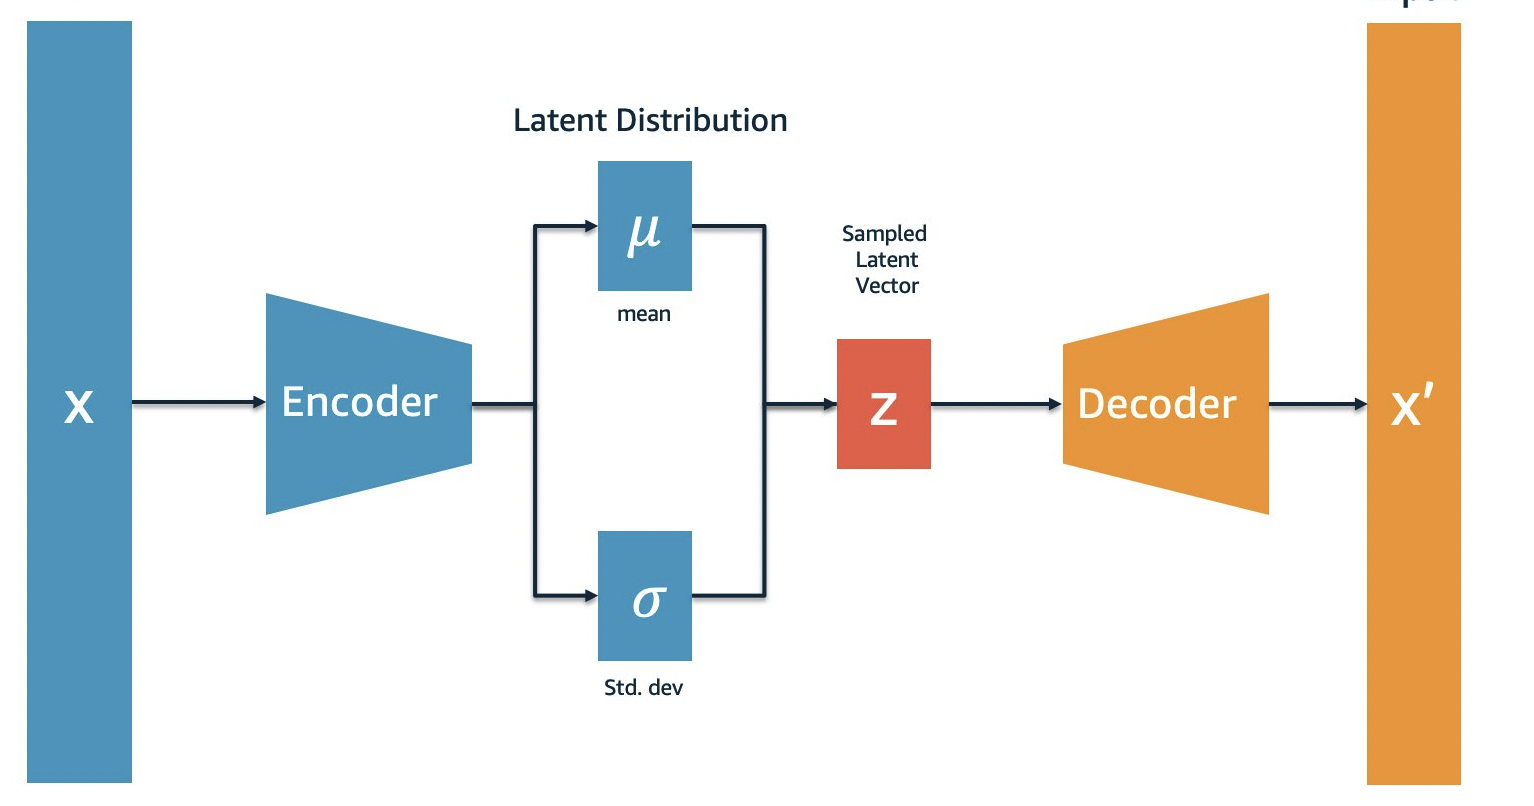

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm 
from keras.datasets import mnist
from keras.utils.vis_utils import plot_model
from keras import backend as K # The backend is important while we are dealing with keras layers and the basic low level operation cannot be handeled by numpy
from keras.losses import mse, binary_crossentropy,CategoricalCrossentropy

In [2]:
data = mnist.load_data()
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train= x_train.reshape(-1,28,28,1) / 255
x_test= x_test.reshape(-1,28,28,1) / 255

In [3]:
# Sampling the latent variable z from the mean and std of the last dense layer 
def sampling(args):

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [4]:
# define the encoder
def encoder():
    encoder1 = layers.Conv2D(32,kernel_size=2,activation='relu',padding='same',name='layer1')(encoder_input)
    encoder2 = layers.MaxPooling2D((2,2),padding='same')(encoder1)
    encoder3 = layers.Conv2D(8,kernel_size=2,activation='relu',padding='same',name='layer2')(encoder2)
    encoder4 = layers.MaxPooling2D((2,2),padding='same')(encoder3)
    encoder5 = layers.Conv2D(8,kernel_size=2,activation='relu',padding='same',name='layer3')(encoder4)
    encoder6 = layers.Flatten()(encoder5)
    encoder_output = layers.Dense(decoder_inputdim,activation=None,name='layer4')(encoder6)
    z_mean = layers.Dense(latent, name='z_mean')(encoder_output)
    z_log_var = layers.Dense(latent, name='z_log_var')(encoder_output)
    z = layers.Lambda(sampling, output_shape=(latent,), name='z')([z_mean, z_log_var])
    encoder_model = Model(encoder_input, [z_mean, z_log_var, z])
    return encoder_model, z_mean, z_log_var



# define the decoder
def decoder():
    decoder_input = keras.Input(shape=(latent,))
    decoder1 = layers.Dense(392,activation=None,name='layer5')(decoder_input)
    decoder2 = layers.Reshape((7,7,8))(decoder1) 
    decoder3 = layers.Conv2D(8,kernel_size=2,padding='same',activation='relu',name='layer6')(decoder2)
    decoder4 = layers.UpSampling2D((2,2))(decoder3)
    decoder5 = layers.Conv2D(32,kernel_size=2,activation='relu',padding='same',name='layer7')(decoder4)
    decoder6 = layers.UpSampling2D((2,2))(decoder5)
    decoder_output = layers.Conv2D(1,kernel_size=2,activation='sigmoid',padding='same',name='layer8')(decoder6)
    decoder_model= Model(decoder_input,decoder_output)
    return decoder_model

##########
latent=3  # Dimensions of the latent space
decoder_inputdim=392 #Dimesions of the flatten layer of the encoder
encoder_input = keras.Input(shape=(28,28,1)) #Dimensions of the input images
##########
encoder_model, z_mean, z_log_var = encoder() # Build the encoder mdoel
decoder_model = decoder() #Build the decoder model
encoder_model.summary(),decoder_model.summary();

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 layer1 (Conv2D)                (None, 28, 28, 32)   160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 32)   0           ['layer1[0][0]']                 
                                                                                                  
 layer2 (Conv2D)                (None, 14, 14, 8)    1032        ['max_pooling2d[0][0]']          
                                                                                              

In [5]:
outputs = decoder_model(encoder_model(encoder_input)[2]) # 2 to return the z parameter
VAE = Model(encoder_input,outputs,name='VAE') # Build the varitional auto encoder

In [6]:
# define the custom loss function as : reconstruction loss function + KL divergence loss function
def Loss(inputs,output):
    inputs = K.flatten(inputs)
    output= K.flatten(outputs)
    #reconstruction_loss = CategoricalCrossentropy(inputs, output)
    reconstruction_loss = mse(inputs, output)
    reconstruction_loss *= decoder_inputdim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    VAE_loss =K.mean(reconstruction_loss + kl_loss)
    return VAE_loss

VAE.add_loss(Loss(encoder_input,outputs)) #add the loss function to the VAE

In [7]:
VAE.compile(optimizer='adam',loss=None) # compile the model with loss=None while we added our custom loss before 

In [8]:
h= VAE.fit(x_train,epochs=10,batch_size=200 ,validation_data=(x_test, None))# fit the model

Epoch 1/10
300/300 [==============================] - 11s 29ms/step - loss: 34.2491 - val_loss: 24.6644
Epoch 2/10
300/300 [==============================] - 8s 28ms/step - loss: 23.4794 - val_loss: 22.9204
Epoch 3/10
300/300 [==============================] - 8s 28ms/step - loss: 22.7752 - val_loss: 22.5841
Epoch 4/10
300/300 [==============================] - 8s 28ms/step - loss: 22.5802 - val_loss: 22.4667
Epoch 5/10
300/300 [==============================] - 8s 28ms/step - loss: 22.4357 - val_loss: 22.3312
Epoch 6/10
300/300 [==============================] - 8s 28ms/step - loss: 22.3235 - val_loss: 22.2052
Epoch 7/10
300/300 [==============================] - 9s 28ms/step - loss: 22.1978 - val_loss: 22.0576
Epoch 8/10
300/300 [==============================] - 9s 31ms/step - loss: 22.0737 - val_loss: 21.9631
Epoch 9/10
300/300 [==============================] - 10s 35ms/step - loss: 21.9643 - val_loss: 21.8322
Epoch 10/10
300/300 [==============================] - 10s 33ms/step - 

In [9]:
  z_mean, _, _ = encoder_model.predict(x_test) # We want to examine the latent space and we are intrested only in the mean value as discrminator in the latent space 

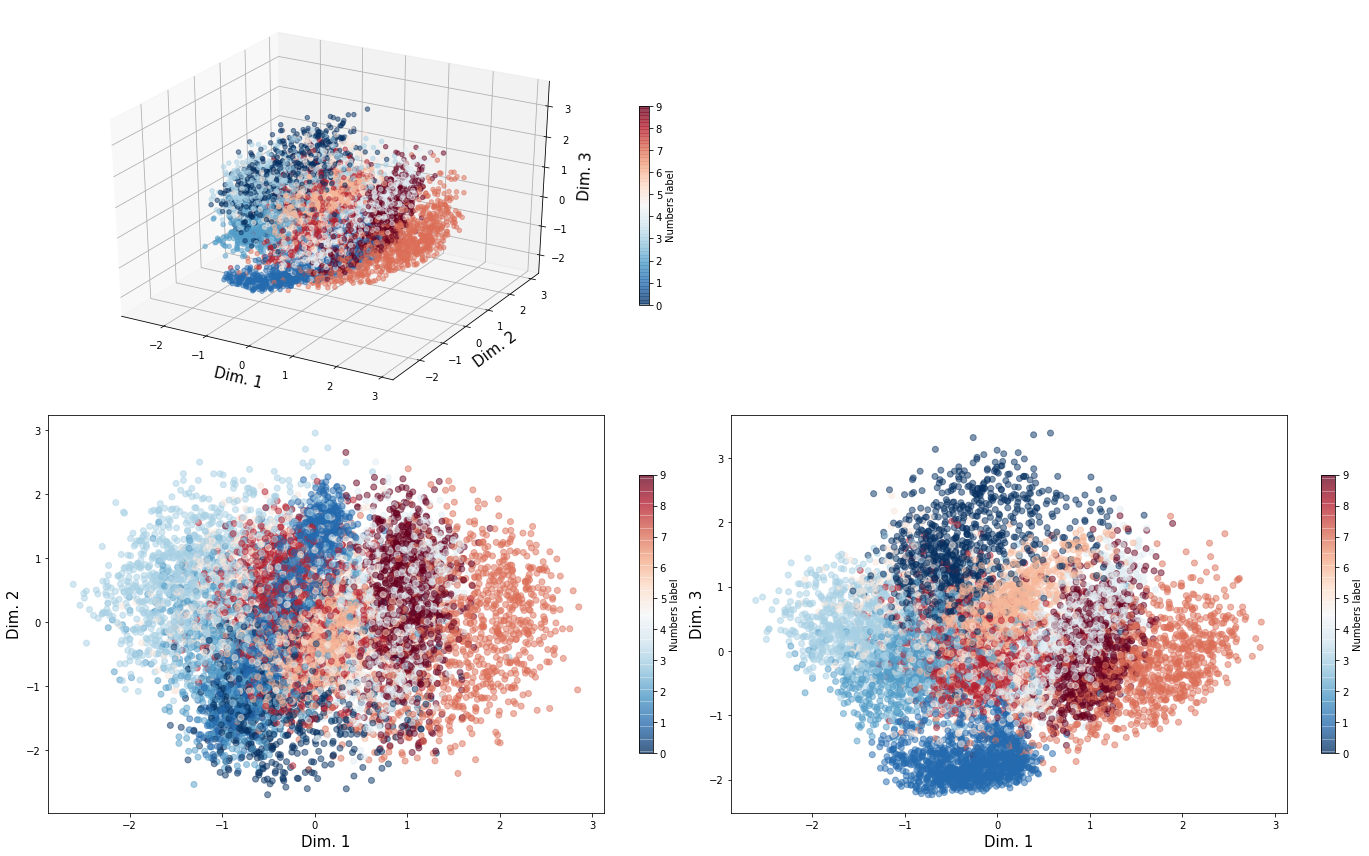

In [22]:
#plot the mean of the latent space
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(221, projection='3d')
c=ax.scatter(z_mean[:, 0], z_mean[:, 1], z_mean[:, 2],c=y_test,cmap='RdBu_r',alpha=0.5);
plt.colorbar(c,shrink=0.5,label='Numbers label');
ax.set_xlabel('Dim. 1',fontsize=15);
ax.set_ylabel('Dim. 2',fontsize=15);
ax.set_zlabel('Dim. 3',fontsize=15);
ax1= fig.add_subplot(223)
c1=ax1.scatter(z_mean[:, 0], z_mean[:, 1],c=y_test,cmap='RdBu_r',alpha=0.5);
plt.colorbar(c1,shrink=0.7,label='Numbers label');
ax1.set_xlabel('Dim. 1',fontsize=15);
ax1.set_ylabel('Dim. 2',fontsize=15);
plt.tight_layout()
ax2= fig.add_subplot(224)
c2=ax2.scatter(z_mean[:, 0], z_mean[:, 2],c=y_test,cmap='RdBu_r',alpha=0.5);
plt.colorbar(c2,shrink=0.7,label='Numbers label');
ax2.set_xlabel('Dim. 1',fontsize=15);
ax2.set_ylabel('Dim. 3',fontsize=15);
plt.tight_layout()


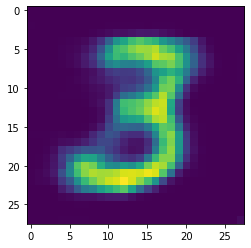

In [37]:
#From the continous distribution of the latent space we can use the decoder to predict the numbers back with using a continous numbers
y_pred=decoder_model.predict([[-2,-0.2,0]]);
plt.imshow(y_pred.reshape(28,28));

# Reduce the input images to images only of 0 or 1 

In [39]:
x1_train = np.concatenate((x_train[y_train==0],x_train[y_train==1]))
x1_test = np.concatenate((x_test[y_test==0],x_test[y_test==1]))
y =[q for q in y_test if q ==0 or q==1]

In [40]:
VAE.fit(x1_train,epochs=10,batch_size=200 ,validation_data=(x1_test, None))# fit the model

Epoch 1/10
64/64 [==============================] - 4s 39ms/step - loss: 15.1893 - val_loss: 14.2510
Epoch 2/10
64/64 [==============================] - 2s 29ms/step - loss: 14.1269 - val_loss: 13.8998
Epoch 3/10
64/64 [==============================] - 2s 32ms/step - loss: 13.8027 - val_loss: 13.3922
Epoch 4/10
64/64 [==============================] - 2s 33ms/step - loss: 13.6240 - val_loss: 13.2377
Epoch 5/10
64/64 [==============================] - 2s 32ms/step - loss: 13.4796 - val_loss: 13.1126
Epoch 6/10
64/64 [==============================] - 2s 31ms/step - loss: 13.3832 - val_loss: 13.0757
Epoch 7/10
64/64 [==============================] - 2s 33ms/step - loss: 13.3121 - val_loss: 13.0379
Epoch 8/10
64/64 [==============================] - 2s 29ms/step - loss: 13.2763 - val_loss: 12.9044
Epoch 9/10
64/64 [==============================] - 2s 33ms/step - loss: 13.2512 - val_loss: 12.9366
Epoch 10/10
64/64 [==============================] - 2s 37ms/step - loss: 13.1766 - val_los

In [41]:
 z1_mean, _, _ = encoder_model.predict(x1_test) # We want to examine the latent space and we are intrested only in the mean value as discrminator in the latent space 

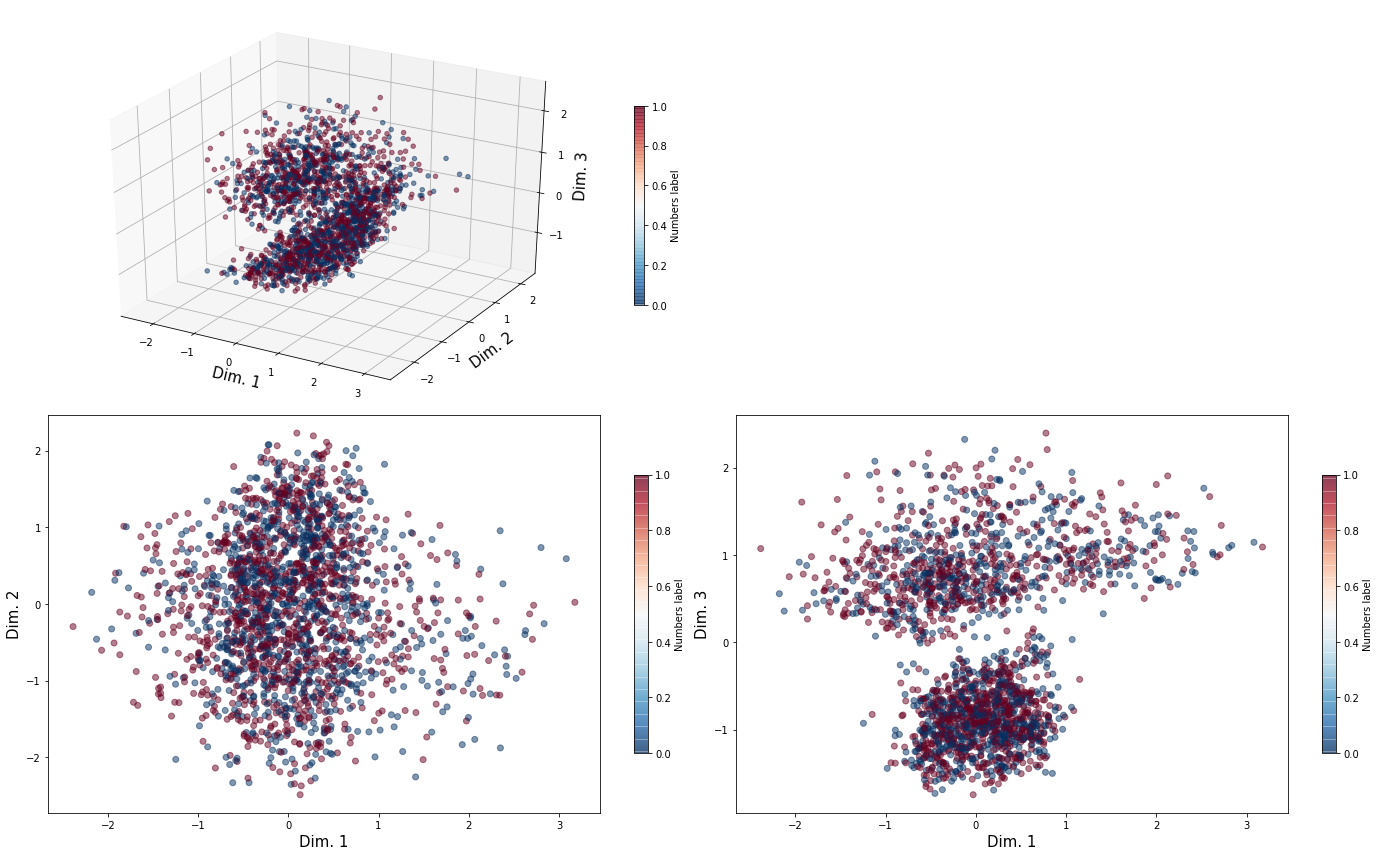

In [43]:
#plot the mean of the latent space
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(221, projection='3d')
c=ax.scatter(z1_mean[:, 0], z1_mean[:, 1], z1_mean[:, 2],c=y,cmap='RdBu_r',alpha=0.5);
plt.colorbar(c,shrink=0.5,label='Numbers label');
ax.set_xlabel('Dim. 1',fontsize=15);
ax.set_ylabel('Dim. 2',fontsize=15);
ax.set_zlabel('Dim. 3',fontsize=15);
ax1= fig.add_subplot(223)
c1=ax1.scatter(z1_mean[:, 0], z1_mean[:, 1],c=y,cmap='RdBu_r',alpha=0.5);
plt.colorbar(c1,shrink=0.7,label='Numbers label');
ax1.set_xlabel('Dim. 1',fontsize=15);
ax1.set_ylabel('Dim. 2',fontsize=15);
plt.tight_layout()
ax2= fig.add_subplot(224)
c2=ax2.scatter(z1_mean[:, 0], z1_mean[:, 2],c=y,cmap='RdBu_r',alpha=0.5);
plt.colorbar(c2,shrink=0.7,label='Numbers label');
ax2.set_xlabel('Dim. 1',fontsize=15);
ax2.set_ylabel('Dim. 3',fontsize=15);
plt.tight_layout()
